# 误警率

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ysy_plot_utils as ypu
import ysy_gw_data_utils as ygdu
import json
from gwpy.timeseries import TimeSeries

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1. 计算事件的得分；
2. 切割 4096s 的数据为 128 个 32s 的数据；
3. 循环，给出得分分布。

In [2]:
json_file_path = 'ysy_BBH_events_v3.json'
with open(json_file_path, 'r') as f:
    all_events_data = json.load(f)
event_info = all_events_data['GW150914']
mf_result = ygdu.matched_filtering_main_2(event_info, plot=False)
cSNR = ygdu.caculate_coherent_snr(event_info)
score = ygdu.detector_consistency_check(mf_result, cSNR)
print('The score is {:4f}'.format(score))

GW150914: For detector H1, maximum at 1126259462.4395 with SNR = 18.6, D_eff = 814.45, horizon = 1889.6 Mpc
GW150914: For detector L1, maximum at 1126259462.4324 with SNR = 13.2, D_eff = 999.78, horizon = 1650.6 Mpc
The score is 0.462660


In [5]:
long_L1 = TimeSeries.read(
    'L-L1_LOSC_4_V2-1126257414-4096.hdf5', 
    format='hdf5.gwosc'
)
long_L1_arr = np.array(long_L1)

In [6]:
start_time = 1126259462.44 - 16
fs = 4096
slice_duration = 32
num = 128
L1_time_series_arr = ygdu.circular_slicer(long_L1_arr, fs, slice_duration, start_time, num)

In [8]:
scores = []
i = 1
N_SLIDES = 10
for time_series in L1_time_series_arr:
    print('Start the '+str(i)+' slice :')
    i = i+1
    scores = scores + ygdu.perform_time_slides(event_info, n_slides=N_SLIDES, extension=True, time_series=time_series)
    print('===================================')

Start the 1 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 2 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 3 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 4 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 5 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 6 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 7 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 8 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 9 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 10 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 11 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 12 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 13 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 14 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 15 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 16 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 17 slice :
正在执行 10 次随机时域平移...
  ...已完成 1/10 次平移
Start the 18 slice :
正在

In [16]:
tot_N = num*N_SLIDES
S_real = score
background_scores = np.array(scores)


正态分布拟合外推法
拟合的正态分布参数: μ (均值) = 0.31, σ (标准差) = 0.05
根据拟合分布，得分>=0.46的概率(FAP)为: 1.10e-03
对应的统计显著性为: 3.06 σ (sigma)


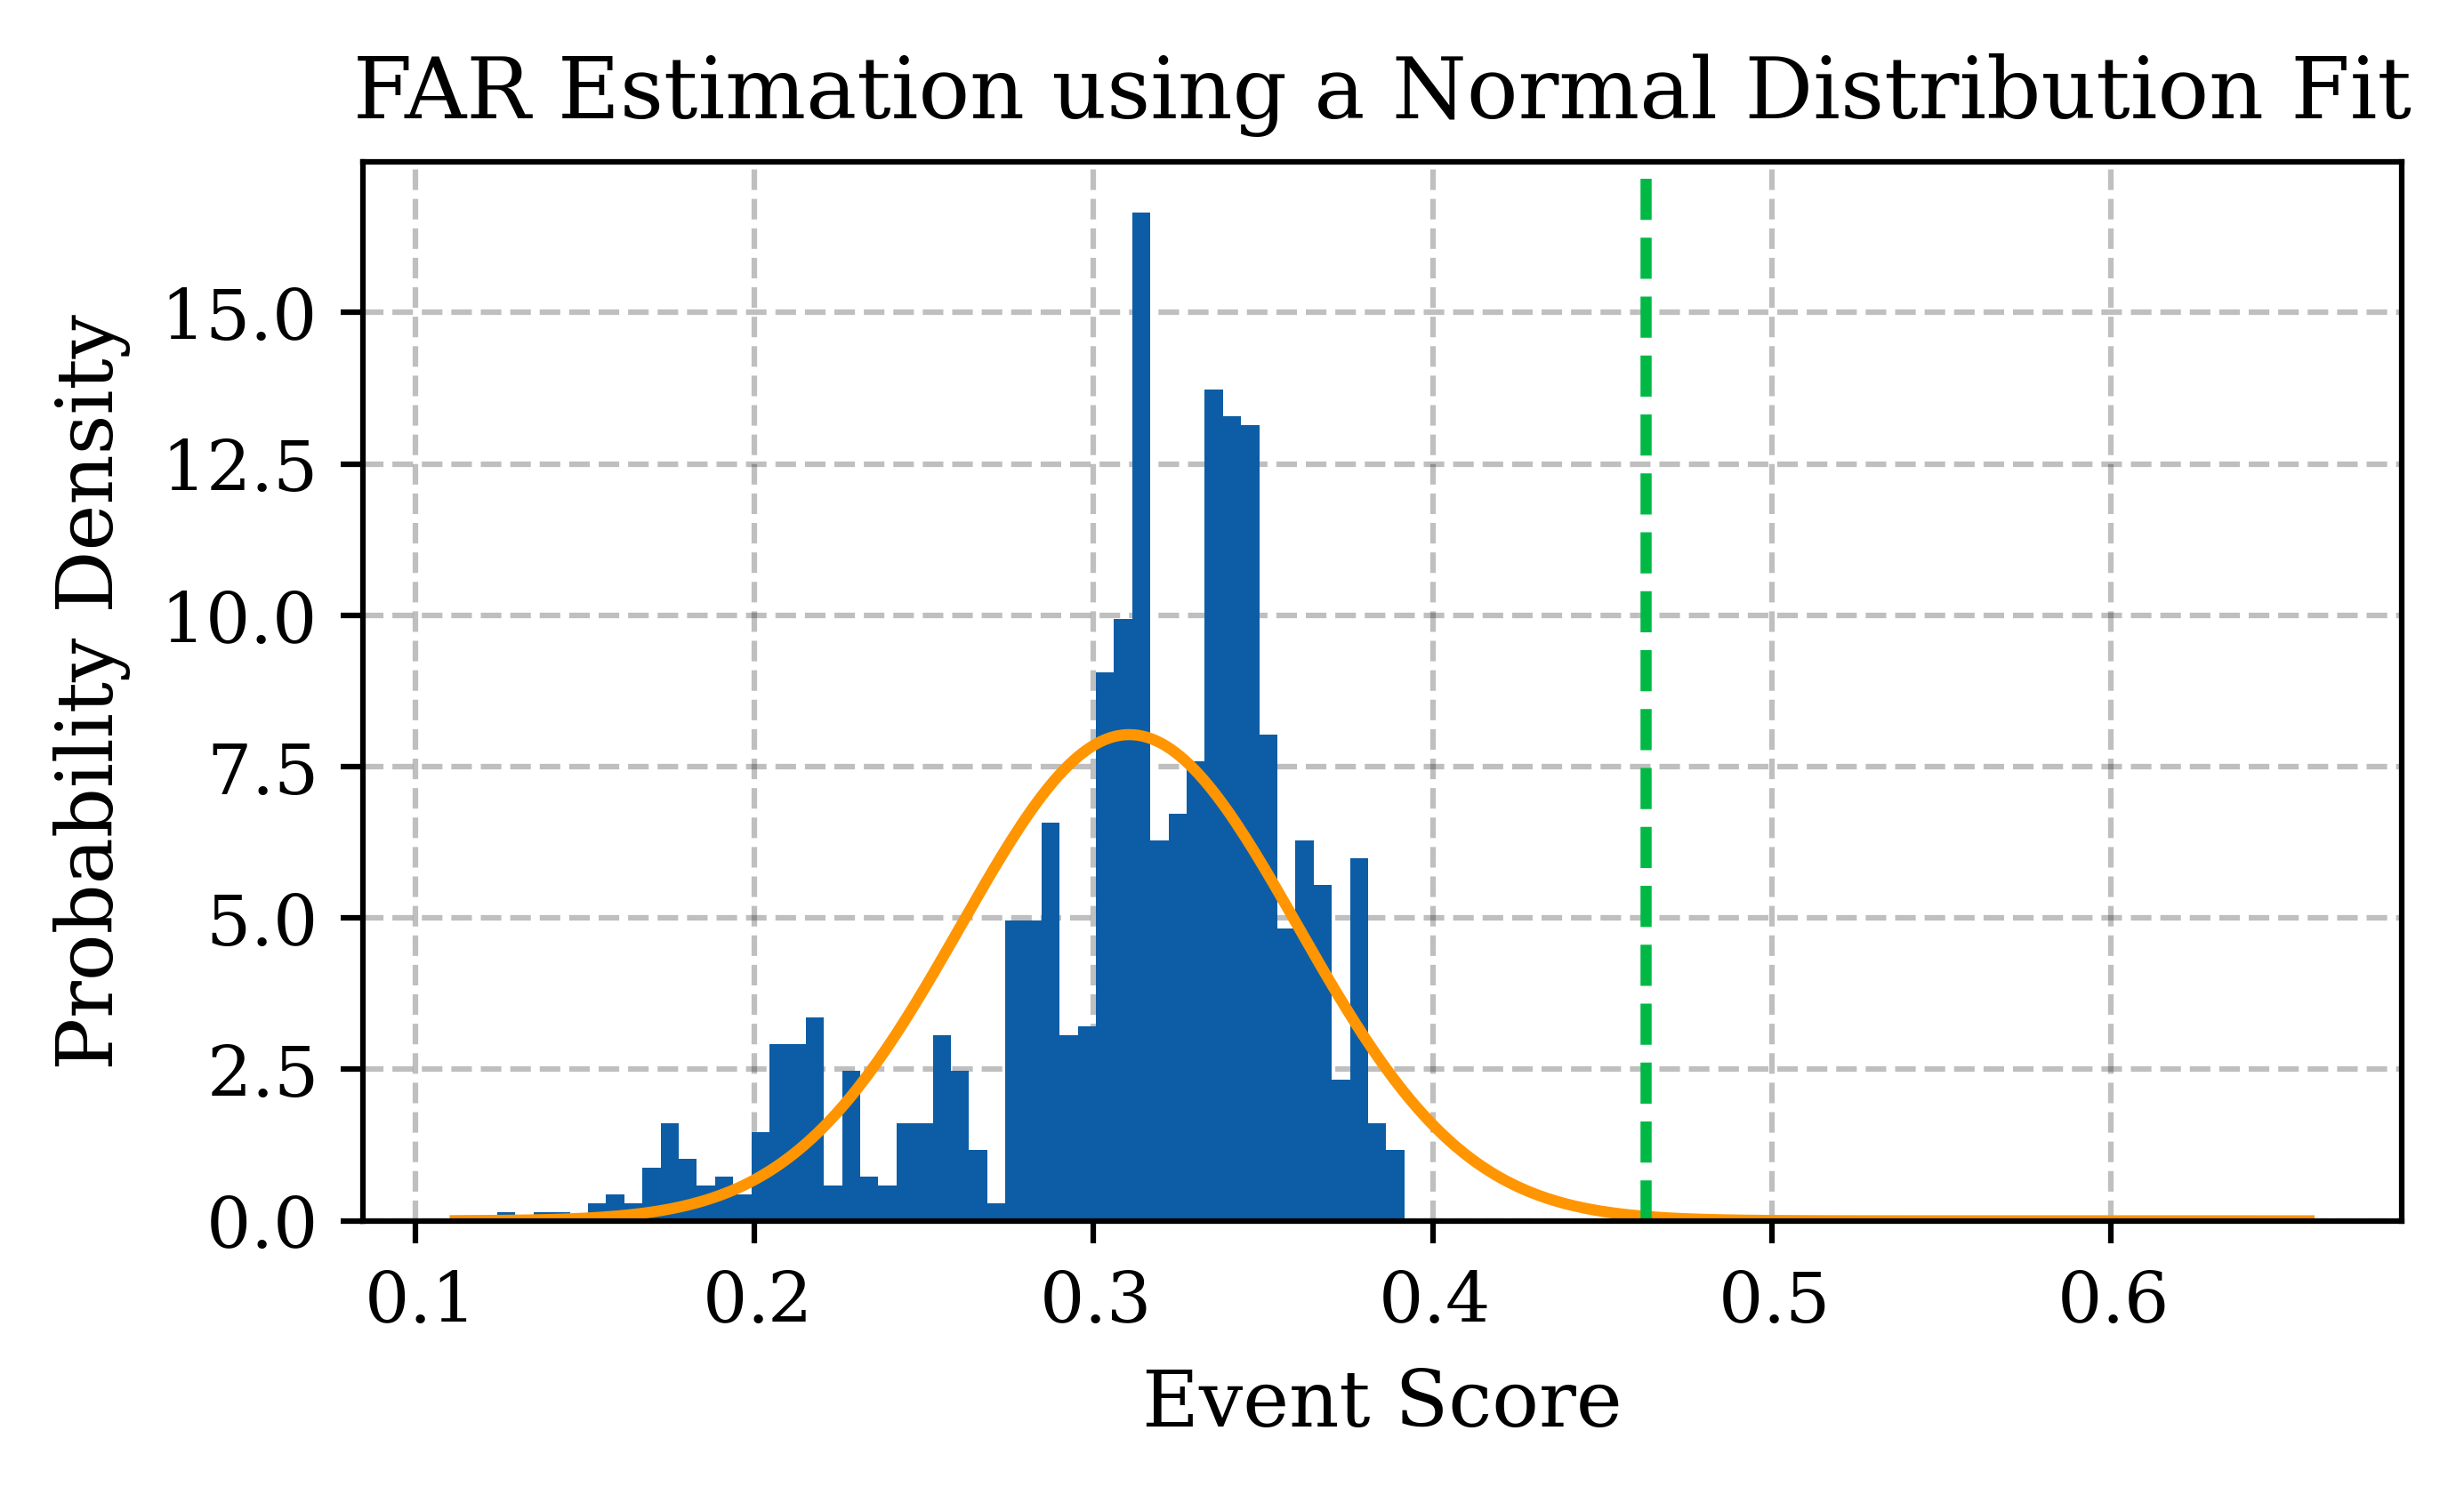

In [20]:
from scipy.stats import norm

def evaluate_far_with_normal_fit(S_real, background_scores):
    """
    通过将正态分布拟合到背景得分，来评估假警报率(FAR)和统计显著性。

    参数:
    S_real (float): 真实候选事件的得分。
    background_scores (np.ndarray): 来自时域平移实验的一系列背景事件得分。

    返回:
    dict: 包含评估结果的字典。
    """
    if not isinstance(background_scores, np.ndarray):
        background_scores = np.array(background_scores)

    # 1. 将正态分布拟合到背景数据上
    # norm.fit() 会返回最佳拟合的均值(mu)和标准差(sigma)
    mu, sigma_dist = norm.fit(background_scores)

    # 2. 计算假警报概率 (False Alarm Probability, FAP)
    # FAP = P(背景得分 >= 真实得分)
    # 我们可以使用生存函数 (Survival Function, sf)，其定义就是 1 - CDF。
    fap_fitted = norm.sf(S_real, loc=mu, scale=sigma_dist)

    # 3. 计算统计显著性 (Significance in sigma)
    # 对于正态分布，这非常直观：就是计算真实得分偏离背景均值多少个标准差。
    # 这也被称为 Z-score。
    significance_sigma = (S_real - mu) / sigma_dist

    # --- 准备结果 ---
    results = {
        'mu': mu,
        'sigma_dist': sigma_dist,
        'fap_fitted': fap_fitted,
        'significance_sigma': significance_sigma
    }
    
    # --- 打印结果 ---
    print("\n正态分布拟合外推法")
    print(f"拟合的正态分布参数: μ (均值) = {mu:.2f}, σ (标准差) = {sigma_dist:.2f}")
    print(f"根据拟合分布，得分>={S_real:.2f}的概率(FAP)为: {fap_fitted:.2e}")
    print(f"对应的统计显著性为: {significance_sigma:.2f} σ (sigma)")
    
    return results

# --- 示例：如何使用此函数 ---
if __name__ == '__main__':
    # --- 步骤二：调用函数进行评估 ---
    fit_results = evaluate_far_with_normal_fit(S_real, background_scores)

    # --- 步骤三：可视化结果 ---
    with ypu.temp_style(["ysy_academic", "science_color"]):
        plt.figure()
        plt.hist(background_scores, bins=50, density=True, alpha=1, label='Background Scores', color='C0')

        # 绘制拟合的正态分布曲线
        mu_fit = fit_results['mu']
        sigma_fit = fit_results['sigma_dist']
        x_axis = np.linspace(mu_fit - 4*sigma_fit, mu_fit + 7*sigma_fit, 400)
        y_axis = norm.pdf(x_axis, loc=mu_fit, scale=sigma_fit)
        plt.plot(x_axis, y_axis, color='C2', label=f'Fitted Normal Distribution\n(μ={mu_fit:.2f}, σ={sigma_fit:.2f})')

        # 标记真实事件的得分位置
        plt.axvline(S_real, color='C1', linestyle='--', label=f'Real Event Score ({S_real:.2f})')

        plt.title('FAR Estimation using a Normal Distribution Fit')
        plt.xlabel('Event Score')
        plt.ylabel('Probability Density')
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

In [ ]:
from scipy.stats import norm, gamma, chi2

def evaluate_far_with_chi2_fit(S_real, background_scores):
    """
    通过将 Chi-squared 分布拟合到背景得分，来评估假警报率和统计显著性。
    """
    print("\n--- 使用 Chi-Squared 分布进行拟合与评估 ---")

    # 1. 将 Chi-squared 分布拟合到背景数据上
    # chi2.fit() 会返回最佳拟合的自由度(df)、位置(loc)和尺度(scale)
    # 我们固定loc=0，因为得分通常从0或一个正数开始
    df, loc, scale = chi2.fit(background_scores, floc=0)

    # 2. 计算假警报概率 (FAP)
    # FAP = P(背景得分 >= 真实得分)
    fap_fitted = chi2.sf(S_real, df, loc=loc, scale=scale)

    # 3. 从概率反算统计显著性 (sigma)
    significance_sigma = norm.ppf(1 - fap_fitted)

    # --- 打印结果 ---
    print(f"[Chi-Squared分布] FAP: {fap_fitted:.2e},  显著性: {significance_sigma:.2f} σ")
    print(f"  拟合参数: df(自由度)={df:.2f}, loc={loc:.2f}, scale={scale:.2f}")
    
    # 返回拟合参数用于可视化
    fit_params = {'df': df, 'loc': loc, 'scale': scale}
    return fit_params

print("--- 对比 Chi-Squared 分布与 Gamma 分布的拟合效果 ---")
print(f"真实事件得分为: {S_real}")

# --- 步骤二：调用新函数进行Chi-squared拟合 ---
chi2_fit_params = evaluate_far_with_chi2_fit(S_real, background_scores)

# --- 作为对比，我们再次运行Gamma拟合 ---
a_gamma, loc_gamma, scale_gamma = gamma.fit(background_scores, floc=0)
fap_gamma = gamma.sf(S_real, a_gamma, loc=loc_gamma, scale=scale_gamma)
sig_gamma = norm.ppf(1 - fap_gamma)
print(f"[伽马分布]       FAP: {fap_gamma:.2e},  显著性: {sig_gamma:.2f} σ")
print(f"  拟合参数: a(形状)={a_gamma:.2f}, loc={loc_gamma:.2f}, scale={scale_gamma:.2f}")


--- 对比 Chi-Squared 分布与 Gamma 分布的拟合效果 ---
真实事件得分为: 0.4626603453981133

--- 使用 Chi-Squared 分布进行拟合与评估 ---
[Chi-Squared分布] FAP: 6.00e-03,  显著性: 2.51 σ
  拟合参数: df(自由度)=66.15, loc=0.00, scale=0.00
[伽马分布]       FAP: 6.00e-03,  显著性: 2.51 σ
  拟合参数: a(形状)=33.08, loc=0.00, scale=0.01
